In [1]:
import numpy as np

import os

from statsmodels.stats.api import DescrStatsW
from scipy.stats import ttest_rel, sem

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def labels_to_counts(labels, time_axis=0):
    onehot = np.zeros((labels.size, n_classes), dtype=int)
    onehot[np.arange(labels.size), labels] = 1
    
    return onehot.cumsum(axis=time_axis)


def log_utility(counts):
    return np.log(counts[:, 1:] + 1).sum(axis=1)


def linear_utility(counts):
    return counts[:, 1:].sum(axis=1)


data = 'morgan'

# group_size = 1
# num_exps = 120
# num_repeats_per_exp = 1

group_size = 5
num_exps = 20
num_repeats_per_exp = 1

policies = [
    'ens jensen greedy',
    # 'classical ens',
    # 'greedy',
    # 'round robin greedy',
]
if group_size == 1 and 'round robin greedy' in policies:
    policies.remove('round robin greedy')
    
utility_function = log_utility

n_classes = group_size + 1
init_size = 1
budget = 500

basepath = os.path.join('../../data/results', data)
# basepath = os.path.join('../../data/results/backup/results 1101 - 1011', data)  # for sorted upperbound 5


utilities = np.ones(
    (len(policies), num_exps, num_repeats_per_exp, budget + init_size)
) * -1

for p_ind, policy in enumerate(policies):
    for exp_ind in range(num_exps):
        path = os.path.join(basepath, f'{data}{exp_ind + 1}', str(group_size), policy)
        for i in range(num_repeats_per_exp):
            labels = np.loadtxt(
                os.path.join(path, f'{policy}__labels__{i + 1}.csv'), 
                dtype=int
            ).flatten() - 1

            utilities[p_ind, exp_ind, i, :] = linear_utility(labels_to_counts(labels))
        
assert np.all(utilities != -1)

OSError: ../../data/results/morgan/morgan10/5/ens jensen greedy/ens jensen greedy__labels__1.csv not found.

In [3]:
utilities.shape

(3, 120, 1, 501)

In [4]:
utilities[..., -1].mean(axis=(1, 2))

array([179.46666667, 180.50833333, 183.01666667])

ens jensen greedy: 179.4667
classical ens: 180.5083
greedy: 183.0167


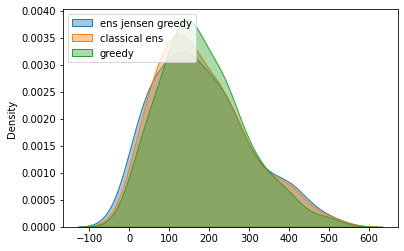

In [5]:
for p_ind, policy in enumerate(policies):
    print(f'{policy}: {utilities[p_ind, ..., -1].mean():.4f}')
    sns.kdeplot(utilities[p_ind, ..., -1].flatten(), alpha=0.4, shade=True, label=policy)
    
plt.legend(loc='upper left');

In [6]:
print(utilities.shape)
utilities

(3, 120, 1, 501)


array([[[[  1.,   1.,   2., ..., 311., 311., 311.]],

        [[  1.,   1.,   1., ..., 293., 293., 293.]],

        [[  1.,   1.,   1., ..., 144., 144., 144.]],

        ...,

        [[  1.,   2.,   3., ..., 234., 234., 234.]],

        [[  1.,   1.,   1., ..., 104., 105., 105.]],

        [[  1.,   1.,   2., ..., 223., 223., 223.]]],


       [[[  1.,   1.,   2., ..., 293., 293., 293.]],

        [[  1.,   1.,   1., ..., 285., 286., 287.]],

        [[  1.,   1.,   1., ..., 144., 144., 144.]],

        ...,

        [[  1.,   2.,   3., ..., 232., 232., 232.]],

        [[  1.,   2.,   3., ..., 100., 101., 101.]],

        [[  1.,   1.,   1., ..., 236., 236., 236.]]],


       [[[  1.,   2.,   3., ..., 179., 179., 179.]],

        [[  1.,   2.,   3., ..., 299., 299., 299.]],

        [[  1.,   2.,   3., ..., 147., 147., 147.]],

        ...,

        [[  1.,   2.,   3., ..., 205., 206., 207.]],

        [[  1.,   1.,   2., ..., 135., 136., 136.]],

        [[  1.,   1.,   1., ..., 256

In [7]:
squeezed_utilities =  utilities.reshape(
    len(policies), 
    num_exps * num_repeats_per_exp, 
    budget + init_size
)

print(squeezed_utilities.shape)
squeezed_utilities

(3, 120, 501)


array([[[  1.,   1.,   2., ..., 311., 311., 311.],
        [  1.,   1.,   1., ..., 293., 293., 293.],
        [  1.,   1.,   1., ..., 144., 144., 144.],
        ...,
        [  1.,   2.,   3., ..., 234., 234., 234.],
        [  1.,   1.,   1., ..., 104., 105., 105.],
        [  1.,   1.,   2., ..., 223., 223., 223.]],

       [[  1.,   1.,   2., ..., 293., 293., 293.],
        [  1.,   1.,   1., ..., 285., 286., 287.],
        [  1.,   1.,   1., ..., 144., 144., 144.],
        ...,
        [  1.,   2.,   3., ..., 232., 232., 232.],
        [  1.,   2.,   3., ..., 100., 101., 101.],
        [  1.,   1.,   1., ..., 236., 236., 236.]],

       [[  1.,   2.,   3., ..., 179., 179., 179.],
        [  1.,   2.,   3., ..., 299., 299., 299.],
        [  1.,   2.,   3., ..., 147., 147., 147.],
        ...,
        [  1.,   2.,   3., ..., 205., 206., 207.],
        [  1.,   1.,   2., ..., 135., 136., 136.],
        [  1.,   1.,   1., ..., 256., 256., 257.]]])

In [8]:
for p1 in range(len(policies) - 1):
    for p2 in range(p1 + 1, len(policies)):
        if squeezed_utilities[p1, :, -1].mean() < squeezed_utilities[p2, :, -1].mean():
            alternative = "less"
        else:
            alternative = "greater"
        
        print(policies[p1], "vs.", policies[p2])
        print(
            ttest_rel(
                squeezed_utilities[p1, :, -1], 
                squeezed_utilities[p2, :, -1],
                alternative=alternative
            ).pvalue
        )
    print()

ens jensen greedy vs. classical ens
0.2911229516979603
ens jensen greedy vs. greedy
0.18174915017240173

classical ens vs. greedy
0.22813465852573384



158.4984892434707 200.43484408986265
10.4841
160.401245791078 200.61542087558865
10.0535
164.19836311345745 201.8349702198759
9.4092


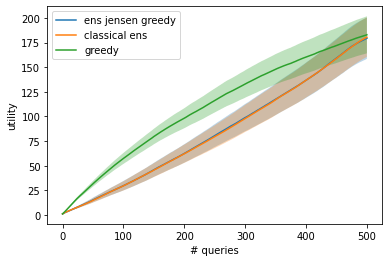

In [9]:
plt.figure()

for p_ind, policy in enumerate(policies):
    plt.plot(squeezed_utilities[p_ind].mean(axis=0), label=policy)
    lower, upper = DescrStatsW(squeezed_utilities[p_ind]).tconfint_mean()
    plt.fill_between(np.arange(init_size + budget), lower, upper, alpha=0.3)
    
    print(lower[-1], upper[-1])
    print(f'{(upper[-1] - lower[-1]) / 4:.4f}')
    
plt.xlabel("# queries")
plt.ylabel("utility")
plt.legend();